<a href="https://colab.research.google.com/github/mjiang9/cs224w-project/blob/main/CS224W_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html


In [ ]:
# Load packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ReLU, BatchNorm1d as BN
import torch.optim as optim
from torch_geometric.nn.conv import MessagePassing

import numpy as np
import sys

from sklearn.model_selection import StratifiedKFold
import sklearn.preprocessing as preprocessing
from sklearn import metrics
from sklearn.cluster import KMeans

from scipy.sparse import linalg
import scipy.sparse as sp

# **GNNs for Detecting Anomalous Users in Wikipedia with Decoupling Representation Learning and Classification**

# Introduction

In this project, our goal is to detect anomalous users in Wikipedia using methods from the paper "[Decoupling Representation Learning and Classification for GNN-based Anomaly Detection](https://xiaojingzi.github.io/publications/SIGIR21-Wang-et-al-decoupled-GNN.pdf)". Most of the code and data are borrowed or adapted from the paper ([source](https://github.com/wyl7/DCI-pytorch)), though the GIN has been rewritten by us using the PyG framework because it was not originally in PyG - our implementation borrows heavily from [this GNN tutorial](https://github.com/sw-gong/GNN-Tutorial). One significant challenge in anomaly detection is the inconsistency between nodes' behavior patterns and label semantics. This paper seeks to alleviate the issue by decoupling the learning of nodes' embeddings from the learning of classifying their labels, rather than learning both in joint training.


First, we load and pre-process the dataset (wiki.txt and wiki_label.txt, as found in the github linked above), a Wikipedia editor-page graph where nodes are users or Wiki pages, and edges denote the pages that a user has edited. The dataset contains public ground truth labels of banned users - the task is to identify these anomalous users.

The code below loads wiki.txt, given as an adjacency matrix, prints some statistics about the graph and its labels, and splits the data for K fold validation. The initial features are loaded here, the next code block will describe the preprocessing done to create them.

In [ ]:
def load_data(datasets, num_folds):
    # load the adjacency
    adj = np.loadtxt('./wiki.txt')
    num_user = len(set(adj[:, 0]))
    num_object = len(set(adj[:, 1]))
    adj = adj.astype('int')
    nb_nodes = np.max(adj) + 1
    edge_index = adj.T
    print('Load the edge_index done!')
    
    # load the user label
    label = np.loadtxt('./wiki_label.txt')
    y = label[:, 1]
    print('Ratio of fraudsters: ', np.sum(y) / len(y))
    print('Number of edges: ', edge_index.shape[1])
    print('Number of users: ', num_user)
    print('Number of objects: ', num_object)
    print('Number of nodes: ', nb_nodes)

    # split the train_set and validation_set
    split_idx = []
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=0)
    for (train_idx, test_idx) in skf.split(y, y):
        split_idx.append((train_idx, test_idx))
   
    # load initial features
    feats = np.load('./wiki_feature64.npy')

    return edge_index, feats, split_idx, label, nb_nodes

Then, for preprocessing, we perform the eigendecomposition and L2-normalize the adjacency matrix, such that 
$$D^{-1/2}AD^{-1/2} = UΛU^T,$$
where D is the degree matrix. Since the original data set does not include side information, the eigenvectors roughly capture the users’ behavior and position similarities, since they preserve the adjacency information.


 

In [ ]:
np.random.seed(0)

def eigen_decomposision(n, k, laplacian, hidden_size, retry):
    laplacian = laplacian.astype("float64")
    ncv = min(n, max(2 * k + 1, 20))
    v0 = np.random.rand(n).astype("float64")
    for i in range(retry):
        try:
            s, u = linalg.eigsh(laplacian, k=k, which="LA", ncv=ncv, v0=v0)
           
        except sparse.linalg.eigen.arpack.ArpackError:
            ncv = min(ncv * 2, n)
            if i + 1 == retry:
                sparse.save_npz("arpack_error_sparse_matrix.npz", laplacian)
                u = torch.zeros(n, k)
        else:
            break
    x = preprocessing.normalize(u, norm="l2")
    x = x.astype("float64")
    return x

def intial_embedding(n, adj, in_degree,hidden_size, retry=10):
    in_degree = in_degree.clip(1) ** -0.5
    norm = sp.diags(in_degree, 0, dtype=float)
    laplacian = norm * adj * norm
    k = min(n - 2, hidden_size)
    x = eigen_decomposision(n, k, laplacian, hidden_size, retry)
    
    return x

def process_adj(dataSetName):
    edges = np.loadtxt(dataSetName).astype('int')
    node_num = len(set(edges[:, 0])) + len(set(edges[:, 1]))

    row = list(edges[:, 0].T) + list(edges[:, 1].T)
    col = list(edges[:, 1].T) + list(edges[:, 0].T)
    data = [1.0 for _ in range(len(row))]
    adj = sp.csr_matrix((data, (row, col)), shape=(node_num, node_num))
    return adj, node_num
    
adj, n = process_adj('./wiki.txt')
hidden_size = 64
in_degree = [np.sum(adj.data[adj.indptr[i]: adj.indptr[i+1]]) for i in range(n)]
in_degree = np.array(in_degree)
x = intial_embedding(n, adj, in_degree, hidden_size, retry=10)
np.save('wiki_feature64.npy', x)

Here we define some other related function. 
1. The **Discriminator** is a function that outputs the affinity scores. 
2. The **AvgReadout** is a average function that applies an average on seq, of shape (batch, nodes, features)

These two concepts are introduced in [Deep Graph Infomax (Veličković et al, ICLR 2019)](https://arxiv.org/pdf/1809.10341.pdf) and the code are borrowed from its corresponding [repository](https://github.com/PetarV-/DGI).



In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_h):
        super(Discriminator, self).__init__()
        self.f_k = nn.Bilinear(n_h, n_h, 1)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, c, h_pl, h_mi, s_bias1=None, s_bias2=None):
        c_x = torch.unsqueeze(c, 1)
        c_x = c_x.expand_as(h_pl)

        sc_1 = torch.squeeze(self.f_k(h_pl, c_x), 2)
        sc_2 = torch.squeeze(self.f_k(h_mi, c_x), 2)

        if s_bias1 is not None:
            sc_1 += s_bias1
        if s_bias2 is not None:
            sc_2 += s_bias2

        logits = torch.cat((sc_1, sc_2), 1)

        return logits

class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, seq, msk):
        if msk is None:
            return torch.mean(seq, 1)
        else:
            msk = torch.unsqueeze(msk, -1)
            return torch.sum(seq * msk, 1) / torch.sum(msk)

# GIN Implementation (PyG)
We arrive at the PyG implementation of the GIN, or Graph Isomorphism Network. For each node $v$, its the $k^{th}$ layer of message processing process is formulated as 

$$
h_{v}^{(k)}=\operatorname{MLP}^{(k)}\left(\left(1+\epsilon^{(k)}\right) \cdot h_{v}^{(k-1)}+\sum_{u \in \mathcal{N}(v)} h_{u}^{(k-1)}\right)
$$

Below is the message passing code for GINConv. Note the message and aggregation functions; the message passed is just the feature itself and the aggregation function here is sum ('add'), and the forward function calls propagate, as usual.


In [ ]:
def reset(nn):
    def _reset(item):
        if hasattr(item, 'reset_parameters'):
            item.reset_parameters()

    if nn is not None:
        if hasattr(nn, 'children') and len(list(nn.children())) > 0:
            for item in nn.children():
                _reset(item)
        else:
            _reset(nn)

class GINConv(MessagePassing):
    def __init__(self, nn, eps: float = 0., train_eps: bool = False,
                 **kwargs):
        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)
        self.nn = nn
        self.initial_eps = eps
        if train_eps:
            self.eps = torch.nn.Parameter(torch.Tensor([eps]))
        else:
            self.register_buffer('eps', torch.Tensor([eps]))
        self.reset_parameters()

    def reset_parameters(self):
        reset(self.nn)
        self.eps.data.fill_(self.initial_eps)


    def forward(self, x, edge_index) -> torch.Tensor:
        if isinstance(x, torch.Tensor):
            x: OptPairTensor = (x, x)

        out = self.propagate(edge_index, x=x)

        x_r = x[1]
        if x_r is not None:
            out += (1 + self.eps) * x_r

        return self.nn(out)


    def message(self, x_j: torch.Tensor) -> torch.Tensor:
        return x_j

    def message_and_aggregate(self, adj_t, x) -> torch.Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x[0], reduce=self.aggr)

The GIN itself is made up of layers of MLPs, which are linear layers followed by ReLU and batch normalization. GIN uses the GINConv message passing that we implemented above.

In [ ]:
class GIN(torch.nn.Module):
    def __init__(self, num_layers, input_dim, hidden):
        super(GIN, self).__init__()
        self.conv1 = GINConv(Sequential(
            Linear(input_dim, hidden),
            ReLU(),
            Linear(hidden, hidden),
            ReLU(),
            BN(hidden),
        ),
                             train_eps=True)
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers - 1):
            self.convs.append(
                GINConv(Sequential(
                    Linear(hidden, hidden),
                    ReLU(),
                    Linear(hidden, hidden),
                    ReLU(),
                    BN(hidden),
                ),
                        train_eps=True))

    def reset_parameters(self):
        self.conv1.reset_parameters()
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        edge_index = edge_index._indices()
        x = self.conv1(x, edge_index)
        for conv in self.convs:
            x = conv(x, edge_index)
        return F.log_softmax(x, dim=-1)

Below is the implementation of DGI as the self-supervised learning scheme. DGI learns the structural similarities of nodes in a global environment by contrasting the whole graph with the node in it. The discriminator outputs the affinity score of each local-global (i.e., node-graph) pair.


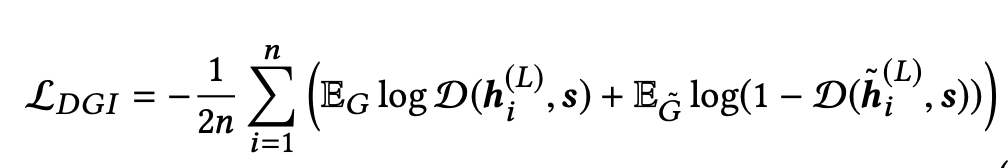

In [ ]:
class DGI(nn.Module):
    def __init__(self, num_layers, input_dim, hidden_dim):
        super(DGI, self).__init__()
        self.gin = GIN(num_layers, input_dim, hidden_dim)
        self.read = AvgReadout()
        self.sigm = nn.Sigmoid()
        self.disc = Discriminator(hidden_dim)

    def forward(self, seq1, seq2, adj, msk, samp_bias1, samp_bias2, lbl):
        criterion = nn.BCEWithLogitsLoss()
        h_1 = torch.unsqueeze(self.gin(seq1, adj), 0)

        c = self.read(h_1, msk)
        c = self.sigm(c)

        h_2 = torch.unsqueeze(self.gin(seq2, adj), 0)
        
        ret = self.disc(c, h_1, h_2, samp_bias1, samp_bias2)

        loss = criterion(ret, lbl)

        return loss

Below is the implementation of DCI as the self-supervised learning scheme. DCI can be viewed as a cluster-based DGI. For DCI, the graph is first partitioned into clusters, which account for neighborhood proximity. After clustering, the paper computes the cluster-level representation for each cluster to summarize how the majority in each cluster act, the discriminator outputs the affinity score of each local-semi-global (i.e., node-cluster) pair, and the final loss function is the average of the losses of the clusters.

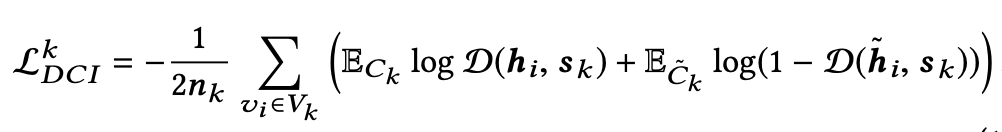

In [ ]:
class DCI(nn.Module):
    def __init__(self, num_layers, input_dim, hidden_dim):
        super(DCI, self).__init__()
        self.gin = GIN(num_layers, input_dim, hidden_dim)
        self.read = AvgReadout()
        self.sigm = nn.Sigmoid()
        self.disc = Discriminator(hidden_dim)

    def forward(self, seq1, seq2, adj, msk, samp_bias1, samp_bias2, cluster_info, cluster_num):
        h_1 = self.gin(seq1, adj)
        h_2 = self.gin(seq2, adj)

        loss = 0
        batch_size = 1
        criterion = nn.BCEWithLogitsLoss()
        for i in range(cluster_num):
            node_idx = cluster_info[i]

            h_1_block = torch.unsqueeze(h_1[node_idx], 0)
            c_block = self.read(h_1_block, msk)
            c_block = self.sigm(c_block)
            h_2_block = torch.unsqueeze(h_2[node_idx], 0)

            lbl_1 = torch.ones(batch_size, len(node_idx))
            lbl_2 = torch.zeros(batch_size, len(node_idx))
            lbl = torch.cat((lbl_1, lbl_2), 1)

            ret = self.disc(c_block, h_1_block, h_2_block, samp_bias1, samp_bias2)
            loss_tmp = criterion(ret, lbl)
            loss += loss_tmp

        return loss / cluster_num
    
    def get_emb(self, seq1, adj):
        h_1 = self.gin(seq1, adj)
        return h_1

The classifier is simply a GIN with a linear prediction layer, we also use dropout.

In [ ]:
class Classifier(nn.Module):
    def __init__(self, num_layers, input_dim, hidden_dim, final_dropout):
        super(Classifier, self).__init__()
        self.gin = GIN(num_layers, input_dim, hidden_dim)
        self.linear_prediction = nn.Linear(hidden_dim, 1)
        self.final_dropout = final_dropout
        
    def forward(self, seq1, adj):
        h_1 = self.gin(seq1, adj)
        score_final_layer = F.dropout(self.linear_prediction(h_1), 
                                      self.final_dropout, 
                                      training = self.training)
        return score_final_layer

# Other Helper Functions
Below are some helper functions for use by the model.

In [ ]:
sig = torch.nn.Sigmoid()

def setup_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True  

def preprocess_neighbors_sumavepool(edge_index, nb_nodes, device):
    adj_idx = edge_index
        
    adj_idx_2 = torch.cat([torch.unsqueeze(adj_idx[1], 0), torch.unsqueeze(adj_idx[0], 0)], 0)
    adj_idx = torch.cat([adj_idx, adj_idx_2], 1)

    self_loop_edge = torch.LongTensor([range(nb_nodes), range(nb_nodes)])
    adj_idx = torch.cat([adj_idx, self_loop_edge], 1)
        
    adj_elem = torch.ones(adj_idx.shape[1])

    adj = torch.sparse.FloatTensor(adj_idx, adj_elem, torch.Size([nb_nodes, nb_nodes]))

    return adj.to(device)

def evaluate(model, test_graph):
    output = model(test_graph[0], test_graph[1])
    pred = sig(output.detach().cpu())
    test_idx = test_graph[3]
    
    labels = test_graph[-1]
    pred = pred[labels[test_idx, 0].astype('int')].numpy()
    target = labels[test_idx, 1]
    
    false_positive_rate, true_positive_rate, _ = metrics.roc_curve(target, pred, pos_label=1)
    auc = metrics.auc(false_positive_rate, true_positive_rate)

    return auc

def finetune(model_pretrain, device, test_graph, feats_num):
    # initialize the joint model
    model = Classifier(N_LAYERS, feats_num, HIDDEN_DIM, DROPOUT).to(device)
    
    # replace the encoder in joint model with the pre-trained encoder
    pretrained_dict = model_pretrain.state_dict()
    model_dict = model.state_dict()
    pretrained_dict =  {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    criterion_tune = nn.BCEWithLogitsLoss()

    res = []
    train_idx = test_graph[2]
    node_train = test_graph[-1][train_idx, 0].astype('int')
    label_train = torch.FloatTensor(test_graph[-1][train_idx, 1]).to(device)
    for _ in range(1, FINETUNE_EPOCHS+1):
        model.train()
        output = model(test_graph[0], test_graph[1])
        loss = criterion_tune(output[node_train], torch.reshape(label_train, (-1, 1)))
        
        #backprop
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # testing
        model.eval()
        auc = evaluate(model, test_graph)
        res.append(auc)

    return np.max(res)

# Model Training and Testing
Below is the main code and results we attained running DCI with the decoupled method/pretraining and with joint training.

In [ ]:
def main_dci(training_scheme):
    setup_seed(0)
    
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

    # data loading
    edge_index, feats, split_idx, label, nb_nodes = load_data("wiki", N_FOLDS)
    input_dim = feats.shape[1]
    # pre-clustering and store userID in each clusters
    kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(feats)
    ss_label = kmeans.labels_
    cluster_info = [list(np.where(ss_label==i)[0]) for i in range(N_CLUSTERS)]
    # the shuffled features are used to contruct the negative sample-pairs
    idx = np.random.permutation(nb_nodes)
    shuf_feats = feats[idx, :]

    adj = preprocess_neighbors_sumavepool(torch.LongTensor(edge_index), nb_nodes, device)
    feats = torch.FloatTensor(feats).to(device)
    shuf_feats = torch.FloatTensor(shuf_feats).to(device)

    # pre-training process
    model_pretrain = DCI(N_LAYERS, input_dim, HIDDEN_DIM).to(device)
    if training_scheme == 'decoupled':
        optimizer_train = optim.Adam(model_pretrain.parameters(), lr=LR)
        for epoch in range(1, EPOCHS + 1):
            model_pretrain.train()
            loss_pretrain = model_pretrain(feats, shuf_feats, adj, None, None, None, cluster_info, N_CLUSTERS)
            if optimizer_train is not None:
                optimizer_train.zero_grad()
                loss_pretrain.backward()         
                optimizer_train.step()
            # re-clustering
            if epoch % RECLUSTER_INTERVAL == 0 and epoch < EPOCHS:
                model_pretrain.eval()
                emb = model_pretrain.get_emb(feats, adj)
                kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(emb.detach().cpu().numpy())
                ss_label = kmeans.labels_
                cluster_info = [list(np.where(ss_label==i)[0]) for i in range(N_CLUSTERS)]
        
        print('Pre-training done!')
            
    #fine-tuning process
    fold_idx = 1
    every_fold_auc = []
    for (train_idx, test_idx) in split_idx:
        test_graph = (feats, adj, train_idx, test_idx, label)
        tmp_auc = finetune(model_pretrain, device, test_graph, input_dim)
        every_fold_auc.append(tmp_auc)
        print('AUC on the Fold'+str(fold_idx)+': ', tmp_auc)
        fold_idx += 1
    print('The averaged AUC score: ', np.mean(every_fold_auc))

In [ ]:
# constants
EPOCHS = 50
N_LAYERS = 2
HIDDEN_DIM = 128
FINETUNE_EPOCHS = 100
N_FOLDS = 10
LR = 0.01
N_CLUSTERS = 2
RECLUSTER_INTERVAL = 20
DROPOUT = 0.5

In [ ]:
main_dci('decoupled')

Load the edge_index done!
Ratio of fraudsters:  0.026376564969004496
Number of edges:  18257
Number of users:  8227
Number of objects:  1000
Number of nodes:  9227
Pre-training done!
AUC on the Fold1:  0.6411587787992282
AUC on the Fold2:  0.6983316309159006
AUC on the Fold3:  0.6708659630007944
AUC on the Fold4:  0.6910963568266939
AUC on the Fold5:  0.6651061173533083
AUC on the Fold6:  0.7769833163091591
AUC on the Fold7:  0.732748836681421
AUC on the Fold8:  0.6703525355210749
AUC on the Fold9:  0.6080197372332203
AUC on the Fold10:  0.6437191605730931
The averaged AUC score:  0.6798382433213895


In [ ]:
main_dci('joint')

Load the edge_index done!
Ratio of fraudsters:  0.026376564969004496
Number of edges:  18257
Number of users:  8227
Number of objects:  1000
Number of nodes:  9227
AUC on the Fold1:  0.7011406196799456
AUC on the Fold2:  0.7355010781977074
AUC on the Fold3:  0.6959482465100443
AUC on the Fold4:  0.7193564862104187
AUC on the Fold5:  0.6726818749290658
AUC on the Fold6:  0.7123482011122461
AUC on the Fold7:  0.7307626830098741
AUC on the Fold8:  0.6488318173711431
AUC on the Fold9:  0.6106949646275489
AUC on the Fold10:  0.7045954461684799
The averaged AUC score:  0.6931861417816474


Below is the main code and results we attained running DGI with the decoupled method/pretraining.

In [ ]:
def main_dgi():
    setup_seed(0)
    
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    # Data loading
    edge_index, feats, split_idx, label, nb_nodes = load_data("wiki", N_FOLDS)
    input_dim = feats.shape[1]
    # the shuffled features are used to contruct the negative samples
    idx = np.random.permutation(nb_nodes)
    shuf_feats = feats[idx, :]

    model_pretrain = DGI(N_LAYERS, input_dim, HIDDEN_DIM).to(device)
    optimizer_train = optim.Adam(model_pretrain.parameters(), lr=LR)

    batch_size = 1
    lbl_1 = torch.ones(batch_size, nb_nodes)
    lbl_2 = torch.zeros(batch_size, nb_nodes)
    lbl = torch.cat((lbl_1, lbl_2), 1).to(device)

    adj = preprocess_neighbors_sumavepool(torch.LongTensor(edge_index), nb_nodes, device)
    feats = torch.FloatTensor(feats).to(device)
    shuf_feats = torch.FloatTensor(shuf_feats).to(device)
    
    # pre-training
    model_pretrain.train()
    for _ in range(1, EPOCHS + 1):
        loss_pretrain = model_pretrain(feats, shuf_feats, adj, None, None, None, lbl)
        if optimizer_train is not None:
            optimizer_train.zero_grad()
            loss_pretrain.backward()         
            optimizer_train.step()
    
    print('Pre-training done!')

    #fine-tuning process
    fold_idx = 1
    every_fold_auc = []
    for (train_idx, test_idx) in split_idx:
        test_graph = (feats, adj, train_idx, test_idx, label)
        tmp_auc = finetune(model_pretrain, device, test_graph, input_dim)
        every_fold_auc.append(tmp_auc)
        print('AUC on the Fold'+str(fold_idx)+': ', tmp_auc)
        fold_idx += 1
    
    print('The averaged AUC score: ', np.mean(every_fold_auc))

In [ ]:
main_dgi()

Load the edge_index done!
Ratio of fraudsters:  0.026376564969004496
Number of edges:  18257
Number of users:  8227
Number of objects:  1000
Number of nodes:  9227
Pre-training done!
AUC on the Fold1:  0.6684542049710589
AUC on the Fold2:  0.7100783112019067
AUC on the Fold3:  0.6609351946430599
AUC on the Fold4:  0.6900181591192827
AUC on the Fold5:  0.6436272840767223
AUC on the Fold6:  0.7140506185450005
AUC on the Fold7:  0.7531210986267167
AUC on the Fold8:  0.607633315498484
AUC on the Fold9:  0.5892931454729208
AUC on the Fold10:  0.6940134355864693
The averaged AUC score:  0.6731224767741621
